## How to Chunk Audio

In principle, smaller chunks lead to better performance, unless the flexibility offered by the smaller chunks is superseeded by the processing time. However, does kNN-VC's performance change depending on the chunk size?

In [55]:
import numpy as np
import torchaudio
import torch
import librosa
from IPython.display import display, Audio
from matplotlib import pyplot as plt

from stream_processing.models.knnvc.converter import Converter, convert_vecs

In [10]:
audiofile = "/Users/cafr02/datasets/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac"
audio = torchaudio.load(audiofile)[0].squeeze()
audio = audio * 32768.0
audio = audio.to(torch.int16)
print(audio.shape)
display(Audio(audio.numpy(), rate=16000))

torch.Size([93680])


In [3]:
converter = Converter(
    device="cpu",
    target_feats_path="../target_feats/135887.pt",
    hifigan_cfg="/Users/cafr02/repos/spkanon/checkpoints/knnvc/hifigan.json",
    hifigan_ckpt="/Users/cafr02/repos/spkanon/checkpoints/knnvc/hifigan.pt",
    wavlm_ckpt="/Users/cafr02/repos/spkanon/checkpoints/WavLM-Large.pt",
    wavlm_layer=6,
    n_neighbors=4,
)
[
    wavlm,
    hifigan,
    target_feats,
    wavlm_layer,
    n_neighbors,
    history,
    time_history,
] = converter.init_callback()

/Users/cafr02/repos/stream_processing/venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...


In [18]:
print("Original")
display(Audio(audio, rate=16000))

# process the whole audio at once
for chunk_size in [1600, 6400, 14999, 29999]:
    out_arr = list()
    history, time_history = list(), list()
    for chunk in range(0, len(audio), chunk_size):
        audio_chunk = audio[chunk : chunk + chunk_size]
        th = torch.tensor([0.])
        time_history = [th, th]
        out = converter.callback(
            th,
            audio_chunk,
            wavlm,
            hifigan,
            target_feats,
            wavlm_layer,
            n_neighbors,
            history,
            time_history,
        )
        if out is not None:
            out_arr.append(out[1])

    out = torch.cat(out_arr)
    print(chunk_size)
    print(out.shape)
    display(Audio(out, rate=16000))

Original


1600
torch.Size([90480])


6400
torch.Size([83200])


14999
torch.Size([74995])


29999
torch.Size([59998])


There is some quality degradation when smaller chunk sizes, mainly at the points where the chunks connect. These could be addressed by small overlaps that are then interpolated.

## VAD simulation

We consider a scenario without noise, where we only have to monitor signal activity and not whether the activity is speech or not. We use the energy thresholding algorithm.

In [41]:
frame_length = 2048
hop_length = 512
energy = librosa.feature.rms(y=audio, hop_length=hop_length, frame_length=frame_length)[0]

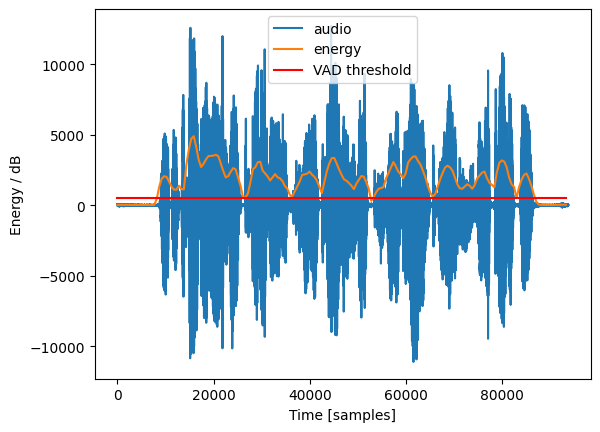

In [48]:
vad_t = 500
n_frames = energy.shape[0]

plt.plot(audio, label="audio")
plt.plot(np.arange(n_frames) * hop_length, energy, label="energy")
plt.plot(np.arange(n_frames) * hop_length, np.ones(n_frames) * vad_t, c="r", label="VAD threshold")
plt.xlabel("Time [samples]")
plt.ylabel("Energy / dB")
plt.legend()
plt.show()

In [54]:
# display the audio for different VAD thresholds

# expand the energy to the same length as the audio
energy_repeat = np.repeat(energy, hop_length)
energy_repeat = energy_repeat[: len(audio)]

for vad_t in [0, 500, 750, 1000, 2000]:
    print(f"VAD threshold: {vad_t}")
    vad = energy_repeat < vad_t
    vad_audio = audio.clone()
    vad_audio[vad] = 0
    display(Audio(vad_audio, rate=16000))

VAD threshold: 0


VAD threshold: 500


VAD threshold: 750


VAD threshold: 1000


VAD threshold: 2000


When the threshold is 1000 or larger, many consonants are removed. 750 works fine for this example, but maybe 500 is better, just to be conservative.

### Conversion + VAD

In [62]:
input_audio = audio.to(torch.float32)
input_audio = input_audio / 32768.0
vad_t = 500
vad_mask = energy_repeat > vad_t

source_feats = wavlm.extract_features(
    input_audio[vad_mask].unsqueeze(0), output_layer=wavlm_layer
)[0]
if source_feats.ndim == 3:
    source_feats = source_feats.squeeze(0)

conv_feats = convert_vecs(source_feats, target_feats, n_neighbors)
out = hifigan(conv_feats.unsqueeze(0)).squeeze()

vad_out = np.zeros(input_audio.shape[0])

print(input_audio.shape)
print(out.shape)
print(vad_mask.shape, vad_mask.sum())

vad_out[vad_mask] = out.detach().numpy()
display(Audio(vad_out, rate=16000))

torch.Size([93680])
torch.Size([77440])
(93680,) 77824


ValueError: NumPy boolean array indexing assignment cannot assign 77440 input values to the 77824 output values where the mask is true